In [21]:
# import tensorflow as tf
# tf.config.run_functions_eagerly(False)
import tensorflow as tf
print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices('GPU'))

/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-05-09 06:39:44.700081: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-09 06:39:44.700129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
tf.test.gpu_device_name()

2022-05-09 06:39:44.705883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-09 06:39:44.705904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'/device:GPU:0'

In [23]:
# Install required packages.
import os
import torch
import numpy as np
from torch.nn import Linear
import statistics
import torch.nn.functional as F

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# # Helper function for visualization.
# %matplotlib inline
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# def visualize(h, color):
#     z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

#     plt.figure(figsize=(10,10))
#     plt.xticks([])
#     plt.yticks([])

#     plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
#     plt.show()

# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

1.11.0


# Graph Neural Networks

In [24]:
from torch_geometric.datasets import Planetoid, Reddit, Flickr, KarateClub, TUDataset, FacebookPagePage
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = Reddit(root='data/Reddit')
#dataset = Flickr(root='data/Flickr')
#dataset = FacebookPagePage(root='data/FacebookPagePage')
#dataset = KarateClub()

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [25]:
def cosine_similarity_finder(node1, node2):
    input1 = node1
    input2 = node2
    cos_sim = torch.nn.CosineSimilarity(dim=0)
    #print(sim)
    sim = cos_sim(node1, node2)
    #print(sim)
    max_val = torch.max(sim)
    min_val = torch.min(sim)
    return sim.item(), max_val, min_val

In [26]:
def similarity_percentage(sim_list):
#     cnt = 0
#     for i in range(len(sim_list)):
# #         print(sim_list[i])
#         if sim_list[i] == 1.0:
#             cnt = cnt+1
#     sim_level = ((cnt*1.0)/(len(sim_list)))*100
    sim_level = abs(sim_list)*100
    #print("Node Similarity Percentage = ", sim_level)
    return sim_level

In [27]:
def node_correlation_plotter(node1, node2, option=1):
    sim, max_val, min_val = cosine_similarity_finder(node1, node2)
    if option == 1:
        new_sim = np.reshape(sim, (len(sim),1))
        #print(len(sim))
        intersection_matrix = np.zeros((len(sim), len(sim)))
        #print(intersection_matrix)
        k=0
        for i in range(0, len(intersection_matrix)):
            for j in range(0, len(intersection_matrix)):
                if i==j:
                    intersection_matrix[i][j] = sim[k]
                    k = k+1
        #print(len(intersection_matrix))
        plt.matshow(intersection_matrix, cmap=plt.cm.Blues)
        for i in range(0, len(intersection_matrix)):
            for j in range(0, len(intersection_matrix)):
                c = intersection_matrix[j,i]
                plt.text(i, j, str(c), va='center', ha='center')
    return sim

In [28]:
# tens_1 = torch.tensor([0.5, 0.3, 1.2, 0.33])
# tens_2 = torch.tensor([0.3, 0.2, 1.3, 1.4])
# # node1 = data.x[0]
# # node2 = data.x[633]
# sim = node_correlation_plotter(torch.reshape(node1, ((node1.size())[0], 1)), torch.reshape(node2, ((node2.size())[0], 1)), 0)
# sim_lev = similarity_percentage(sim)
# print(sim_lev)

In [29]:
def make_edge_dictionary(edge_data):
    edge_dict={}
    for i in range(edge_data.size()[0]):
        x = edge_data.tolist()
        temp = []
        if x[i][0] in edge_dict:
            temp = edge_dict[x[i][0]]
        temp.append(x[i][1])
        edge_dict[x[i][0]] = temp
        #print(edge_dict[x[i][0]])
    return edge_dict

In [30]:
# MAKE EDGE DICTIONARY
# node1 = torch.tensor([1, 2, 3, 4], dtype=torch.float)
# print(node1.size())
# node2 = torch.tensor([1, 2, 2, 4], dtype=torch.float)
# node_correlation_plotter(torch.reshape(node1, ((node1.size())[0], 1)), torch.reshape(node2, ((node2.size())[0], 1)), 0)
edge_data = data.edge_index.t()
edge_dict = make_edge_dictionary(edge_data)
print(edge_dict)

{0: [633, 1862, 2582], 1: [2, 652, 654], 2: [1, 332, 1454, 1666, 1986], 3: [2544], 4: [1016, 1256, 1761, 2175, 2176], 5: [1629, 1659, 2546], 6: [373, 1042, 1416, 1602], 7: [208], 8: [269, 281, 1996], 9: [723, 2614], 10: [476, 2545], 11: [1655, 1839], 12: [1001, 1318, 2661, 2662], 13: [1701, 1810], 14: [158, 2034, 2075, 2077, 2668], 15: [1090, 1093, 1271, 2367], 16: [970, 1632, 2444, 2642], 17: [24, 927, 1315, 1316, 2140], 18: [139, 1560, 1786, 2082, 2145], 19: [1939], 20: [1072, 2269, 2270, 2374, 2375], 21: [1043, 2310], 22: [39, 1234, 1702, 1703, 2238], 23: [2159], 24: [17, 201, 598, 1636, 1701, 2139, 2141], 25: [1301, 1344, 2011, 2317], 26: [99, 122, 123, 2454, 2455], 27: [606, 1810, 2360, 2578], 28: [1687], 29: [963, 2645], 30: [697, 738, 1358, 1416, 2162, 2343], 31: [1594], 32: [279, 518, 1850, 1973], 33: [286, 588, 698, 911, 1051, 2040, 2119, 2120, 2121], 34: [1358], 35: [895, 1296, 1913], 36: [1146, 1505, 1552, 1640, 1781, 2094, 2106, 2107], 37: [60, 1190, 2427], 38: [429, 862, 8

GENERIC FRAMEWORK FOR GNN

In [31]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_layers, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(dataset.num_features, hidden_channels))
        if num_layers > 1:
            for i in range(num_layers-2):
                self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.convs.append(GCNConv(hidden_channels, 2))
            self.classifier = Linear(2, dataset.num_classes)
        else:
            self.classifier = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, num_layers):
        h=x
        for l in range(num_layers-1):
            h = self.convs[l](h, edge_index)
            h = h.tanh()
#             h = F.dropout(h, p=0.5, training=self.training)
#         if num_layers > 1:
#             h = torch.nn.functional.relu(h)
        h = self.convs[num_layers-1](h, edge_index)
        h = h.tanh()
#             #h = torch.nn.functional.relu(h)
#             #h = F.dropout(h, p=0.5, training=self.training)
#             h = self.convs[l](h, edge_index)
#             #h = h.tanh()
#           else:
#             #h = torch.nn.functional.dropout(h, dropout=0.5, training=self.training)
#             h = self.convs[l](h, edge_index)
#             #h = h.tanh()
#             h = h.relu()
#             h = F.dropout(h, p=0.5, training=self.training)
        out = self.classifier(h)
            #x = F.dropout(x, p=0.5, training=self.training)
        return out, h

model = GCN(3, hidden_channels=4)
print(model)

GCN(
  (convs): ModuleList(
    (0): GCNConv(1433, 4)
    (1): GCNConv(4, 4)
    (2): GCNConv(4, 2)
  )
  (classifier): Linear(in_features=2, out_features=7, bias=True)
)


In [32]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

def init_model(num_layers):
      model = GCN(num_layers, hidden_channels=16)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
      criterion = torch.nn.CrossEntropyLoss()
      return model, optimizer, criterion

def train(model, optimizer, criterion, num_layers):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out, h = model(data.x, data.edge_index, num_layers)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      # Calculate training accuracy on our four examples
#       predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
#       target_classes = data.y[data.train_mask]
#       accuracy = torch.mean(torch.where(predicted_classes == target_classes, 1, 0).float())
#       predicted_classes = torch.argmax(out, axis=1)
#       target_classes = data.y
#       accuracy_val = torch.mean(torch.where(predicted_classes == target_classes, 1, 0).float())
      accuracy = 0
      accuracy_val = 0
      return out, h, loss, accuracy, accuracy_val

def train_test(model, optimizer, criterion, num_layers):
      model.eval()
      out, h = model(data.x, data.edge_index, num_layers)
      predicted_classes = torch.argmax(out[data.train_mask], axis=1)
      target_classes = data.y[data.train_mask]
      #train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
      #print(out)
      train_acc = torch.mean(torch.where(predicted_classes == target_classes, 1, 0).float())
      predicted_classes = torch.argmax(out, axis=1)
      target_classes = data.y
      accuracy_val = torch.mean(torch.where(predicted_classes == target_classes, 1, 0).float())
      return train_acc, accuracy_val

def test(model, optimizer, criterion, num_layers):
      model.eval()
      out = model(data.x, data.edge_index, num_layers)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def call_train(model, optimizer, criterion, num_layers):
    for epoch in range(1, 101):
        out, h, loss, accuracy, accuracy_val = train(model, optimizer, criterion, num_layers)
        if epoch==0 or epoch%100==0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    accuracy, accuracy_val = train_test(model, optimizer, criterion, num_layers)
    return out, h, accuracy, accuracy_val

<IPython.core.display.Javascript object>

In [33]:
def modeler(num_layers):
      model, optimizer, criterion = init_model(num_layers)
      out_x, h, accuracy, accuracy_val = call_train(model, optimizer, criterion, num_layers)
      #test_acc = test(model, optimizer, criterion, num_layers)*100
      #test_accuracy_list.append(test_acc)
      #train_acc = train_test(model, optimizer, criterion, num_layers)*100
      train_accuracy_list.append(accuracy.item())
      val_accuracy_list.append(accuracy_val.item())
      #print(f'Test Accuracy: {test_acc:.4f}')
      print(f'Train Accuracy: {accuracy:.4f}')
      print(f'Val Accuracy: {accuracy_val:.4f}')
      return model, out_x, h

In [34]:
# def node_similarity_simulator(output):
#     output_similarity_matrix = []
#     output_similarity_percentages = []
#     for i in range(output.size()[0]):
#         for j in range(output.size()[0]):
#             if i in edge_dict and i<j:
#                 if edge_dict[i].count(j)>0:
#                     sim = node_correlation_plotter(torch.reshape(output[i], ((output[i].size())[0], 1)), torch.reshape(output[j], ((output[j].size())[0], 1)), 0)
#                     output_similarity_matrix.append(sim)
#                     entry = []
#                     entry.append(i)
#                     entry.append(j)
#                     entry.append(similarity_percentage(sim))
#                     output_similarity_percentages.append(entry)
#                 else
#     return output_similarity_matrix, output_similarity_percentages

In [35]:
# ## SKIP NON CONNECTED EDGES
# def node_similarity_simulator(output):
#     output_similarity_matrix = []
#     output_similarity_matrix_plot = []
#     output_similarity_percentages = []
#     print(output.size()[0])
#     for i in range(output.size()[0]):
#         temper = []
#         for j in range(output.size()[0]):
#             if i in edge_dict and edge_dict[i].count(j)>0:
#                 sim = node_correlation_plotter(output[i], output[j], 0)
#                 output_similarity_matrix.append(sim)
#                 temper.append(round(float(sim),2))
#                 entry = []
#                 entry.append(i)
#                 entry.append(j)
#                 entry.append(similarity_percentage(sim))
#                 output_similarity_percentages.append(entry)
#             else:
#                 output_similarity_matrix.append(0.0)
#                 temper.append(0.0)
#         output_similarity_matrix_plot.append(temper)
#     return output_similarity_matrix, output_similarity_percentages, output_similarity_matrix_plot

In [36]:
## CONSIDER NON CONNECTED EDGES
def node_similarity_simulator(output):
    output_similarity_matrix = []
    output_similarity_matrix_plot = []
    output_similarity_percentages = []
    print(output.size()[0])
    for i in range(output.size()[0]):
        temper = []
        for j in range(output.size()[0]):
            #sim = node_correlation_plotter(torch.reshape(output[i], ((output[i].size())[0], 1)), torch.reshape(output[j], ((output[j].size())[0], 1)), 0)
            sim = node_correlation_plotter(output[i], output[j], 0)
            output_similarity_matrix.append(sim)
            #print(sim)
            temper.append(round(float(sim),4))
            entry = []
            entry.append(i)
            entry.append(j)
            entry.append(similarity_percentage(sim))
            output_similarity_percentages.append(entry)
        output_similarity_matrix_plot.append(temper)
    return output_similarity_matrix, output_similarity_percentages, output_similarity_matrix_plot

In [37]:
def get_one(x):
    if x>0:
        return 1
    else:
        return 0

In [38]:
def get_DTGT(output_similarity_matrix, M, DTGT):
    ans = torch.mul(torch.tensor(output_similarity_matrix), torch.tensor(M))
    l = len(output_similarity_matrix)
    for i in range(l):
        temp = ans[i]
        temp_sum = torch.sum(temp)
        x = []
        for j in range(temp.size()[0]):
            x.append(get_one(temp[j]))
        x_sum = torch.sum(torch.tensor(x), 0)
        DTGT[i] = ((temp_sum)/x_sum).item()
    return DTGT

In [39]:
def mad_calc(DTGT):
    temp = DTGT
    #print(temp.tolist())
    temp_sum = torch.sum(torch.tensor(DTGT))
    #print(temp_sum)
    x = []
    for j in range(len(temp)):
        x.append(get_one(temp[j]))
    x_sum = torch.sum(torch.tensor(x), 0)
    MAD = (temp_sum)/x_sum
    #print(MAD)
    return MAD

In [40]:
def find_MAD(output_similarity_matrix, output_similarity_percentages):
    l = len(output_similarity_matrix)
    M = np.zeros((l, l))
    DTGT = np.zeros((l, 1))
    for i in range(l):
        for j in range(l):
            M[i][j]=1.0
    DTGT = get_DTGT(output_similarity_matrix, M, DTGT)
    where_are_NaNs = np.isnan(DTGT)
    DTGT[where_are_NaNs] = 0
    MAD = mad_calc(DTGT)
    return MAD

In [41]:
# from numpy import mean, absolute
# def mad(data, axis=None):
#     return mean(absolute(data - mean(data, axis)), axis)

# def mad_calc(output_similarity_matrix, output_similarity_percentages):
#     l = len(output_similarity_matrix)
#     for i in range(len(output_similarity_matrix)):
#         temp = output_similarity_matrix[i]
#         mad_temp = mad(temp)
#         print(mad_temp)

In [42]:
# ## WITHOUT MAD
# test_accuracy_list = []
# train_accuracy_list = []
# xpoints = []
# MAD_SCORES = []
# def layer_modeler(m):
#     for i in range(m, m+1):
#         print("######### LAYER = ", i, " #######")
#         xpoints.append(i)
#         model = modeler(i)
#         #if i==m:
#         model.eval()
#         output = model(data.x, data.edge_index, i)
#         output_similarity_matrix, output_similarity_percentages, output_similarity_matrix_plot = node_similarity_simulator(output)
#         #print(output_similarity_matrix)
#             #visualize(output, color=data.y)
#         print(model)
# #         mad_calc(output_similarity_matrix, output_similarity_percentages)
# #         mad_score = find_MAD(output_similarity_matrix, output_similarity_percentages)
# #         MAD_SCORES.append(mad_score.item())
#         return output_similarity_matrix, output_similarity_percentages, output_similarity_matrix_plot

In [43]:
def find_cosine_distance_matrix(output_similarity_matrix_plot):
    cosine_diff_matrix = []
    for i in range(len(output_similarity_matrix_plot)):
        temp = []
        for j in range(len(output_similarity_matrix_plot)):
            temp.append((1-output_similarity_matrix_plot[i][j]))
        cosine_diff_matrix.append(temp)
    return cosine_diff_matrix

In [44]:
import math
def euc_dist(tensor1, tensor2):
    dist = torch.dist(tensor1, tensor2, 2) 
    return dist.item()
def get_row_diff(node_array, N):
    eud_dist_mat = []
    for i in range(len(node_array)):
        temp = []
        for j in range(len(node_array)):
            if i!=j:
                eud = euc_dist(torch.tensor(node_array[i]), torch.tensor(node_array[j]))
                temp.append(eud)
        row_sum_node = torch.sum(torch.tensor(temp))
        row_sum_avg = row_sum_node/(N-1)
        eud_dist_mat.append(row_sum_avg)
    return eud_dist_mat
def row_diff_finder(node_array, N):
    row_diff = get_row_diff(node_array, N)
    row_diff_sum = torch.sum(torch.tensor(row_diff))
    differ = row_diff_sum/(N)
    return differ

In [45]:
import statistics
def similarity_aggregation(sim_matrix):
    avg_sim = statistics.mean(sim_matrix)
    return avg_sim

In [46]:
# WITH MAD
test_accuracy_list = []
train_accuracy_list = []
val_accuracy_list = []
avg_sim_list = []
xpoints = []
MAD_SCORES = []
def layer_modeler(m):
    for i in range(m, m+1):
        print("######### LAYER = ", i, " #######")
        xpoints.append(i)
        model, out_x, h = modeler(i)
#         model.eval()
#         output = model(data.x, data.edge_index, i)
        #transformation(h)
        output_similarity_matrix, output_similarity_percentages, output_similarity_matrix_plot = node_similarity_simulator(h)
        print(model)
        avg_sim = similarity_aggregation(output_similarity_matrix)
        avg_sim_list.append(avg_sim)
        cosine_diff_matrix = find_cosine_distance_matrix(output_similarity_matrix_plot)
        mad_score = find_MAD(cosine_diff_matrix, output_similarity_percentages)
        MAD_SCORES.append(mad_score.item())
        #print(output)
        row_diff = row_diff_finder(h.tolist(), len(output_similarity_matrix_plot))
        #if i==m:
            #visualize(h, color=data.y)
        return output_similarity_matrix, output_similarity_percentages, output_similarity_matrix_plot, row_diff, cosine_diff_matrix

In [47]:
def arrival(m):
    sim_mat = []
    row_diff_mat = []
    diff_mat = []
    for i in range(2, m+1):
        output_similarity_matrix, output_similarity_percentages, output_similarity_matrix_plot, row_diff, cosine_diff_matrix = layer_modeler(i)
        #print(output_similarity_matrix_plot)
        sim_mat.append(output_similarity_matrix_plot)
        print(np.asarray(output_similarity_matrix_plot).shape)
        row_diff_mat.append(row_diff)
        diff_mat.append(cosine_diff_matrix)
    return sim_mat, row_diff_mat, diff_mat

In [48]:
def gotcha(m, rows, cols, sim):
    row=0
    col = 0
    fig, ax = plt.subplots(rows, cols,
                       sharex='col', 
                       sharey='row', figsize=(10,5))
    for i in range(0, len(sim)):
        if col <3:
            ax[row, col].matshow(sim[i], cmap=plt.cm.Blues)
            st = "Depth = "+str(i+1)
            ax[row, col].title.set_text(st)
            col = col + 1
        else:
            row = row + 1
            col = 0
            ax[row, col].matshow(sim[i], cmap=plt.cm.Blues)
            st = "Depth = "+str(i+1)
            ax[row, col].title.set_text(st)
            col = col + 1
    plt.tight_layout()
    plt.show()

In [49]:
similarity_scores, row_differences, difference_scores = arrival(8)

######### LAYER =  2  #######
Epoch: 100, Loss: 0.8815
Train Accuracy: 0.7143
Val Accuracy: 0.6027
2708
GCN(
  (convs): ModuleList(
    (0): GCNConv(1433, 16)
    (1): GCNConv(16, 2)
  )
  (classifier): Linear(in_features=2, out_features=7, bias=True)
)
(2708, 2708)
######### LAYER =  3  #######
Epoch: 100, Loss: 0.8198
Train Accuracy: 0.8429
Val Accuracy: 0.5399
2708
GCN(
  (convs): ModuleList(
    (0): GCNConv(1433, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 2)
  )
  (classifier): Linear(in_features=2, out_features=7, bias=True)
)
(2708, 2708)
######### LAYER =  4  #######
Epoch: 100, Loss: 1.0053
Train Accuracy: 0.4643
Val Accuracy: 0.3102
2708
GCN(
  (convs): ModuleList(
    (0): GCNConv(1433, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 16)
    (3): GCNConv(16, 2)
  )
  (classifier): Linear(in_features=2, out_features=7, bias=True)
)
(2708, 2708)
######### LAYER =  5  #######
Epoch: 100, Loss: 0.9025
Train Accuracy: 0.5929
Val Accuracy: 0.4856
2708
GCN(
  (convs): Modu

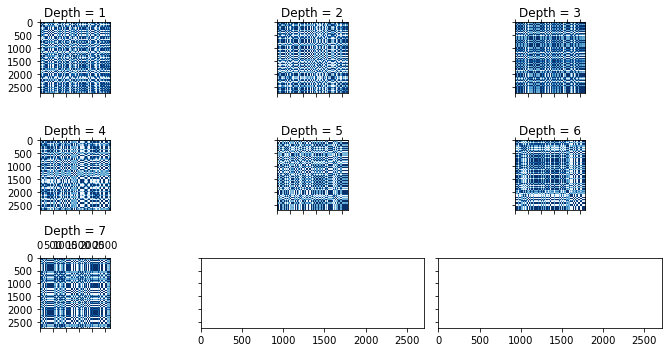

In [50]:
import math
m = 8
gotcha(m, 3, 3, similarity_scores)

In [51]:
# import math
# m = 7
# gotcha(m, 2, 3, difference_scores)

In [52]:
print(avg_sim_list)

[0.09327591149324932, 0.0794488366738088, 0.24303429368420768, 0.03306891644029567, 0.12599278268712705, 0.14923936118619052, 0.10895852579317551]


In [53]:
print(MAD_SCORES)

[0.9124240967499833, 0.9431267204203557, 0.8540384957614519, 1.0270229256348298, 1.0122550997528874, 1.050952624183544, 1.1980850368409666]


In [54]:
row_differences

[tensor(1.0705),
 tensor(1.3833),
 tensor(1.3210),
 tensor(1.5469),
 tensor(1.4447),
 tensor(1.4489),
 tensor(1.4588)]

In [55]:
print(train_accuracy_list)

[0.7142857313156128, 0.8428571224212646, 0.4642857015132904, 0.5928571224212646, 0.7071428298950195, 0.5714285969734192, 0.3928571343421936]


In [56]:
print(val_accuracy_list)

[0.6026588082313538, 0.5398818254470825, 0.3101920187473297, 0.48559823632240295, 0.4279911518096924, 0.4239290952682495, 0.3401033878326416]


In [57]:
acc = [train_accuracy_list, val_accuracy_list]

In [58]:
acc

[[0.7142857313156128,
  0.8428571224212646,
  0.4642857015132904,
  0.5928571224212646,
  0.7071428298950195,
  0.5714285969734192,
  0.3928571343421936],
 [0.6026588082313538,
  0.5398818254470825,
  0.3101920187473297,
  0.48559823632240295,
  0.4279911518096924,
  0.4239290952682495,
  0.3401033878326416]]

In [59]:
# def euc_dist(tensor1, tensor2):
#     dist = torch.dist(tensor1, tensor1, 2) 
#     return dist.item()
# def get_row_diff(node_array):
#     eud_dist_mat = []
#     for i in range(len(node_array)):
#         temp = []
#         for j in range(len(node_array)):
#             #print(node_array[j])
#             eud = euc_dist(torch.tensor(node_array[i]), torch.tensor(node_array[j]))
#             temp.append(eud)
#         eud_dist_mat.append(temp)
#     return eud_dist_mat

In [60]:
# datax = data.x.tolist()
# row_diff = get_row_diff(datax)

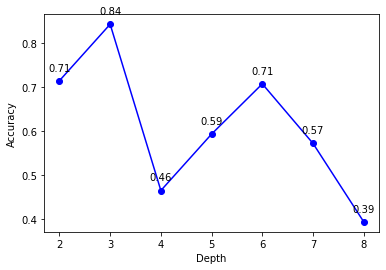

In [61]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.array(xpoints)
ypoints = np.array(train_accuracy_list)
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.plot(xpoints, ypoints, 'ob-')
for x,y in zip(xpoints,ypoints):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()


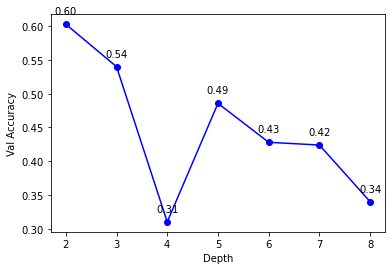

In [62]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.array(xpoints)
ypoints = np.array(val_accuracy_list)
plt.xlabel("Depth")
plt.ylabel("Val Accuracy")
plt.plot(xpoints, ypoints, 'ob-')
for x,y in zip(xpoints,ypoints):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()


In [63]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame({"Training": train_accuracy_list,
                 "Validation" : val_accuracy_list})
p = sns.lineplot(data = df)
p.set( xlabel = "Layers", ylabel = "Accuracy")

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame({"Training": train_accuracy_list,
                 "Validation" : val_accuracy_list})
p = sns.lineplot(data = df)
p.set( xlabel = "Layers", ylabel = "Accuracy")

In [ ]:
#print(output_similarity_percentages)

In [ ]:
# for i in range(len(output_similarity_percentages)):
#         print("Node i = " , output_similarity_percentages[i][0], ", Node j = ", output_similarity_percentages[i][1], " Similarity Percentage = ", output_similarity_percentages[i][2])

In [ ]:
#print(output_similarity_matrix)
# print(len(output_similarity_matrix))

In [ ]:
# print(output_similarity_matrix_plot)

In [ ]:
# np.asarray(output_similarity_matrix_plot).shape

In [ ]:
# def similarity_plotter(output_similarity_matrix_plot):
# #     intersection_matrix = np.zeros((len(output_similarity_matrix_plot), len(output_similarity_matrix_plot)))
# #     for i in range(0, len(output_similarity_matrix_plot)):
# #         for j in range(0, len(output_similarity_matrix_plot[i])):
# #             intersection_matrix[i][j]= output_similarity_matrix_plot[i][j][0]
#     plt.matshow(output_similarity_matrix_plot, cmap=plt.cm.Blues)
# #     for i in range(0, len(output_similarity_matrix_plot)):
# #         for j in range(0, len(output_similarity_matrix_plot)):
# #             c = output_similarity_matrix_plot[i][j]
# #             plt.text(i, j, str(c), va='center', ha='center')

In [ ]:
# similarity_plotter(sim)

In [ ]:
# def gotcha(m):
#     rows, cols = 3, 3
#     sim = arrival(m)
#     row=0
#     col = 0
#     fig, ax = plt.subplots(rows, cols,
#                        sharex='col', 
#                        sharey='row', figsize=(10,5))
#     for i in range(0, len(sim)):
#         if col <3:
#             ax[row, col].matshow(sim[i], cmap=plt.cm.Blues)
#             st = "Depth = "+str(i+2)
#             ax[row, col].title.set_text(st)
#             col = col + 1
#         else:
#             row = row + 1
#             col = 0
#             ax[row, col].matshow(sim[i], cmap=plt.cm.Blues)
#             st = "Depth = "+str(i+2)
#             ax[row, col].title.set_text(st)
#             col = col + 1
#     plt.tight_layout()
#     plt.show()

In [ ]:
# gotcha(10)

In [ ]:

# fig, ax = plt.subplots(rows, cols,
#                        sharex='col', 
#                        sharey='row')

# for row in range(rows):
#     for col in range(cols):
#         ax[row, col].text(0.5, 0.5, 
#                           str((row, col)),
#                           color="green",
#                           fontsize=18, 
#                           ha='center')

# plt.show()

In [ ]:
# def group_by_node():
#     node_group={}
#     for i in range(len(output_similarity_percentages)):
#         temp = []
#         if output_similarity_percentages[i][0] in node_group:
#             temp = node_group[output_similarity_percentages[i][0]]
#         temp.append(output_similarity_percentages[i][2])
#         node_group[output_similarity_percentages[i][0]] = temp
#     return node_group

In [ ]:
# node_grouping = group_by_node()

In [ ]:
# node_grouping

In [ ]:
# import statistics
# def aggr_by_node():
#     node_aggr={}
#     for i in range(len(output_similarity_percentages)):
#         temp = []
#         if output_similarity_percentages[i][0] in node_grouping:
#             temp = node_grouping[output_similarity_percentages[i][0]]
#         node_aggr[output_similarity_percentages[i][0]] = statistics.mean(temp)
#     return node_aggr

In [ ]:
# aggr = aggr_by_node()

In [ ]:
# list_aggr = list(aggr.values())

In [ ]:
# mean_aggr = statistics.mean(list_aggr)

In [ ]:
# mean_aggr

In [ ]:
# l = len(output_similarity_matrix)
# M = np.zeros((l, l))
# DTGT = np.zeros((l, 1))
# for i in range(l):
#     for j in range(l):
#         M[i][j]=1.0

In [ ]:
# def get_one(x):
#     if x>0:
#         return 1
#     else:
#         return 0

In [ ]:
# ans = torch.mul(torch.tensor(output_similarity_matrix), torch.tensor(M))
# #print(ans)
# for i in range(l):
#     temp = ans[i]
#     temp_sum = torch.sum(temp)
#     x = []
#     for j in range(temp.size()[0]):
#         x.append(get_one(temp[j]))
#     x_sum = torch.sum(torch.tensor(x))
#     DTGT[i] = ((temp_sum*1.0)/x_sum).item()

In [ ]:
# where_are_NaNs = np.isnan(DTGT)
# DTGT[where_are_NaNs] = 0

In [ ]:
# temp = DTGT
# temp_sum = torch.sum(torch.tensor(temp))
# x = []
# for j in range(len(temp)):
#     x.append(get_one(temp[j]))
# x_sum = torch.sum(torch.tensor(x))
# MAD = (temp_sum*1.0)/x_sum

In [ ]:
# print(MAD.item())